# Overview

Smartphones and mobile applications, indispensable parts of our lives, can make our daily tasks extremely easy. However, these applications designed to cater to all users can fall short when it comes to personalizing the user experience. Although all users carry out their tasks through the same mobile application, each user has certain menus they prioritize. Recommending these menus in a personalized manner that meets customer needs will save time and significantly enhance the user experience with a personalized interface. Improvements can be made in this area with the help of recommendation mechanisms and machine learning.

What is required is to develop an artificial intelligence model with the usage data of a mobile application and recommend the menu each user will need most in that application. In the dataset, the target indicates 9 menus that each user preferred in their past usage, shown in binary format. We need to predict which 3 of these 9 menus will be added to the user interface.

#### File Descriptions
• train_final.parquet - Training dataset
• test_final.parquet - Test dataset
• submission_sample_final.parquet - Sample submission file in the correct format

The training dataset contains data from October/November/December of 2022, while the test dataset contains data from January 2023.


## Train and Test Data Sets

#### ID
Masked customer ID

#### MONTH
The month the transaction was made

#### N_SECONDS_[*]
Time spent on menus (provided in order of targets)

#### CARRIER
Phone line on which the transaction was made

#### DEVICEBRAND
Brand of the device where the transaction was made

#### FEATURE_[*]
Masked attributes representing customer-specific data

#### TARGET
The top 3 menus where the customer spent the most time in a particular month

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost
from catboost import CatBoostClassifier

# Preprocess

In [2]:
train_dataset = pd.read_parquet('train_final.parquet')
#test_dataset = pd.read_parquet('test_final.parquet')
#sample_submission = pd.read_parquet('submission_sample_final.parquet')

#### Creating Columns for Multi-label Binary Classification 

In [3]:
train_dataset['menu_items'] = train_dataset['target'].str.split(', ')

def add_columns(df, column):
    menus = ['menu1', 'menu2', 'menu3', 'menu4', 'menu5', 'menu6', 'menu7', 'menu8', 'menu9']   
    for menu in menus:
        df[menu] = df[column].apply(lambda x: 1 if menu in x else 0)

add_columns(train_dataset, "menu_items")
train_dataset.drop('menu_items', axis=1, inplace=True)

#### Editing Categorical Columns

In [4]:
carrier_mapping = {
    'VODAFONE TR': 'VODAFONE',
    'VODAFONE UK': 'VODAFONE',
    'VODAFONE.DE': 'VODAFONE',
    'TELEKOM.DE':'TURKTELEKOM',
    'TT': 'TURK TELEKOM',
    'KKTCELL': 'TURKCELL',
    'TELEKOM': 'TURKTELEKOM',
    'TURK TELEKOM': 'TURKTELEKOM',
    'LIFECELL TR':'LIFECELL',
    'O2-DE': 'O2',
    'O2 - DE': 'O2',
    'AVEA': 'TURKTELEKOM',
    'TEKNOSA': 'TEKNOSACELL',
    'TEKNOSACEL': 'TEKNOSACELL',
    'VODAFONE TÜRKIYE': 'VODAFONE',
    'TURK TELEKOM | AVEA': 'TURKTELEKOM',
    'VF NL': 'VODAFONE',
    'O2 - DE+': 'O2',
    'TR TURKCELL': 'TURKCELL' 
}

train_dataset['carrier'] = train_dataset['carrier'].map(carrier_mapping).fillna(train_dataset['carrier'])
carrier_companies = ["VODAFONE", "TURKTELEKOM", "BIMCELL", "TURKCELL", "FENERCELL", 
"GSMOBILE", "PTTCELL", "LIFECELL","O2", "AZERCELL", "ASIACELL", "TEKNOSACELL",
"ALMADAR", "IRANCELL", "VESTELCELL", "T-MOBILE", "OOREDOO"]  

train_dataset['updated_carrier'] = train_dataset['carrier'].copy()
train_dataset['updated_carrier'] = train_dataset['carrier'].apply(lambda x: x if x in carrier_companies else "OTHER")

def distribute_other_based_on_proportion(series, carrier_companies):
    known_carriers = series[series.isin(carrier_companies)]
    proportions = known_carriers.value_counts(normalize=True)
    other_indices = series[series == "OTHER"].index
    new_values = np.random.choice(proportions.index, size=len(other_indices), p=proportions.values)
    series.loc[other_indices] = new_values
    
    return series

train_dataset['updated_carrier'] = distribute_other_based_on_proportion(train_dataset['updated_carrier'], carrier_companies)
train_dataset['updated_carrier'].value_counts()

/var/folders/x3/pkxr6fs91b9dt9nf608j0q100000gn/T/ipykernel_1446/1198603744.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[other_indices] = new_values


updated_carrier
TURKCELL       41054
VODAFONE       27196
TURKTELEKOM    22911
BIMCELL         1140
TEKNOSACELL      596
PTTCELL          439
LIFECELL         188
O2               155
FENERCELL        139
GSMOBILE          82
T-MOBILE          62
AZERCELL          21
OOREDOO           21
ASIACELL          18
ALMADAR           10
VESTELCELL         9
IRANCELL           8
Name: count, dtype: int64

In [5]:
devicebrand_mapping = {
    'gm': 'GM',
    'samsung': 'SAMSUNG',
    'Apple': 'APPLE',
    'Redmi':'REDMI',
    'xiaomi': 'XIAOMI',
    'Casper': 'CASPER',
    'lge': 'LG',
    'Realme': 'REALME',
    'Vestel':'VESTEL',
    'vivo': 'VIVO',
    'reeder': 'REEDER',
    'Reeder': 'REEDER',
    'Sony': 'SONY',
    'OnePlus': 'ONEPLUS',
    'Lenovo': 'LENOVO',
    'asus': 'ASUS',
    'Infinix': 'INFINIX',
    'Nokia': 'NOKIA',
    'google': 'GOOGLE',
    'Realme': 'REALME',
    'motorola': 'MOTOROLA',
    'htc': 'HTC',
    'Alcatel': 'ALCATEL',
    'Meizu': 'MEIZU',
    'generalmobile': 'GM',
    'Huawei': 'HUAWEI'
}

train_dataset['devicebrand'] = train_dataset['devicebrand'].map(devicebrand_mapping).fillna(train_dataset['devicebrand'])
device_companies = ["GM", "SAMSUNG", "APPLE", "REDMI", "XIAOMI", 
                    "CASPER", "LG", "REALME", "VESTEL", "VIVO", "REEDER", "SONY",
                    "ONEPLUS", "LENOVO", "ASUS", "INFINIX", "NOKIA", "MOTOROLA", "HTC", 
                    "MEIZU", "HUAWEI", "GOOGLE"]  

train_dataset['updated_devicebrand'] = train_dataset['devicebrand'].copy()
train_dataset['updated_devicebrand'] = train_dataset['devicebrand'].apply(lambda x: x if x in device_companies else "OTHER")

def distribute_other_based_on_proportion(series, device_companies):
    known_devices = series[series.isin(device_companies)]
    proportions = known_devices.value_counts(normalize=True)
    other_indices = series[series == "OTHER"].index
    new_values = np.random.choice(proportions.index, size=len(other_indices), p=proportions.values)
    series.loc[other_indices] = new_values
    
    return series

train_dataset['updated_devicebrand'] = distribute_other_based_on_proportion(train_dataset['updated_devicebrand'], device_companies)
train_dataset['updated_devicebrand'].value_counts()

/var/folders/x3/pkxr6fs91b9dt9nf608j0q100000gn/T/ipykernel_1446/3488442253.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[other_indices] = new_values


updated_devicebrand
APPLE       35367
SAMSUNG     34075
REDMI        8215
HUAWEI       7032
XIAOMI       5667
GM           1023
LG            472
CASPER        308
VESTEL        269
VIVO          255
REEDER        250
SONY          237
ONEPLUS       202
LENOVO        186
ASUS          172
INFINIX        67
NOKIA          60
GOOGLE         58
MEIZU          54
MOTOROLA       33
HTC            31
REALME         16
Name: count, dtype: int64

In [6]:
import statistics

def create_stdev(df, x, y):
    for col in df.iloc[:, x:y].columns:
        stdev_value = statistics.stdev(df[col])
        df[col + '_stdev'] = stdev_value

# Assuming train_dataset is a previously defined DataFrame
create_stdev(train_dataset, 7, 57)

In [7]:
# features 
feature_calculation = train_dataset.iloc[:, 7:57]  # Assuming this slices all your feature columns
train_dataset["features_mean"] = feature_calculation.mean(axis=1)
#train_dataset["features_max"] = feature_calculation.max(axis=1)
train_dataset["features_median"] = feature_calculation.median(axis=1)
train_dataset["features_stdev"] = feature_calculation.std(axis=1)


In [8]:
train_dataset.iloc[:, 69:119]

,feature_0_stdev,feature_1_stdev,feature_2_stdev,feature_3_stdev,feature_4_stdev,feature_5_stdev,feature_6_stdev,feature_7_stdev,feature_8_stdev,feature_9_stdev,...,feature_40_stdev,feature_41_stdev,feature_42_stdev,feature_43_stdev,feature_44_stdev,feature_45_stdev,feature_46_stdev,feature_47_stdev,feature_48_stdev,feature_49_stdev
0,0.706014,0.742521,0.855615,1.001878,0.886168,0.765429,0.693982,0.661974,0.841732,0.889535,...,0.745859,0.767093,0.812613,0.910212,0.797621,0.83725,0.858325,0.642435,8.31033,12.950021
1,0.706014,0.742521,0.855615,1.001878,0.886168,0.765429,0.693982,0.661974,0.841732,0.889535,...,0.745859,0.767093,0.812613,0.910212,0.797621,0.83725,0.858325,0.642435,8.31033,12.950021
2,0.706014,0.742521,0.855615,1.001878,0.886168,0.765429,0.693982,0.661974,0.841732,0.889535,...,0.745859,0.767093,0.812613,0.910212,0.797621,0.83725,0.858325,0.642435,8.31033,12.950021
3,0.706014,0.742521,0.855615,1.001878,0.886168,0.765429,0.693982,0.661974,0.841732,0.889535,...,0.745859,0.767093,0.812613,0.910212,0.797621,0.83725,0.858325,0.642435,8.31033,12.950021
4,0.706014,0.742521,0.855615,1.001878,0.886168,0.765429,0.693982,0.661974,0.841732,0.889535,...,0.745859,0.767093,0.812613,0.910212,0.797621,0.83725,0.858325,0.642435,8.31033,12.950021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94044,0.706014,0.742521,0.855615,1.001878,0.886168,0.765429,0.693982,0.661974,0.841732,0.889535,...,0.745859,0.767093,0.812613,0.910212,0.797621,0.83725,0.858325,0.642435,8.31033,12.950021
94045,0.706014,0.742521,0.855615,1.001878,0.886168,0.765429,0.693982,0.661974,0.841732,0.889535,...,0.745859,0.767093,0.812613,0.910212,0.797621,0.83725,0.858325,0.642435,8.31033,12.950021
94046,0.706014,0.742521,0.855615,1.001878,0.886168,0.765429,0.693982,0.661974,0.841732,0.889535,...,0.745859,0.767093,0.812613,0.910212,0.797621,0.83725,0.858325,0.642435,8.31033,12.950021
94047,0.706014,0.742521,0.855615,1.001878,0.886168,0.765429,0.693982,0.661974,0.841732,0.889535,...,0.745859,0.767093,0.812613,0.910212,0.797621,0.83725,0.858325,0.642435,8.31033,12.950021


In [9]:
# Creating a function to process the csv files
def process_csv(file_path):
    csv_data = pd.read_csv(file_path, skiprows=1)
    csv_data.iloc[:, 0] = pd.to_datetime(csv_data.iloc[:, 0])
    csv_data.set_index(csv_data.columns[0], inplace=True)
    monthly_means = csv_data.resample('M').mean()
    relevant_means = monthly_means['2022-10':'2023-01']
    return dict(zip(['10', '11', '12', '01'], relevant_means.iloc[:, 0].values))

#google_sigorta = process_csv("google_sigorta.csv")
#google_işbankası = process_csv("google_işbankası.csv")
google_hisse_senedi = process_csv("google_hisse_senedi.csv")
google_borsa = process_csv("google_borsa.csv")
google_halka_arz = process_csv("google_halka_arz.csv")
google_faiz = process_csv("google_faiz.csv") # Redundant, but for consistency
google_döviz = process_csv("google_döviz.csv")
google_vergi_borcu = process_csv("google_vergi_borcu.csv")
google_benzin = process_csv("google_benzin.csv")

#train_dataset['google_sigorta'] = train_dataset['month'].astype(str).map(google_sigorta)
#train_dataset['google_işbankası'] = train_dataset['month'].astype(str).map(google_işbankası)
train_dataset['google_hisse_senedi'] = train_dataset['month'].astype(str).map(google_hisse_senedi)
train_dataset['google_borsa'] = train_dataset['month'].astype(str).map(google_borsa)
train_dataset['google_halka_arz'] = train_dataset['month'].astype(str).map(google_halka_arz)
train_dataset['google_faiz'] = train_dataset['month'].astype(str).map(google_faiz)
train_dataset['google_döviz'] = train_dataset['month'].astype(str).map(google_döviz)
train_dataset['google_vergi_borcu'] = train_dataset['month'].astype(str).map(google_vergi_borcu)


# n_seconds 
train_dataset["n_seconds_mean"] = (train_dataset["n_seconds_1"] + train_dataset["n_seconds_2"] + train_dataset["n_seconds_3"]) / 3

# features 
feature_calculation = train_dataset.iloc[:, 7:57]  # Assuming this slices all your feature columns
train_dataset["features_mean"] = feature_calculation.mean(axis=1)
#train_dataset["features_max"] = feature_calculation.max(axis=1)
train_dataset["features_median"] = feature_calculation.median(axis=1)
train_dataset["features_stdev"] = feature_calculation.std(axis=1)
train_dataset["features_variance"] = feature_calculation.var(axis=1)

# importing rate documents
bist100_csv = pd.read_csv("bist100.csv")
bitcoin_csv = pd.read_csv("bitcoin.csv")
ethereum_csv = pd.read_csv("ethereum.csv")
altin_csv = pd.read_csv("altin.csv")
euro_csv = pd.read_csv("euro.csv")
dolar_csv = pd.read_csv("dolar.csv")

# dollar rate
dolar_mean_10 = dolar_csv.iloc[0:28, 3].mean(axis = 0)
dolar_mean_11 = dolar_csv.iloc[28:58, 3].mean(axis = 0)
dolar_mean_12 = dolar_csv.iloc[58:89, 3].mean(axis = 0)
dolar_mean_01 = dolar_csv.iloc[89:120, 3].mean(axis = 0)
dolar = {'10': dolar_mean_10,
        '11': dolar_mean_11,
        '12': dolar_mean_12,
        '01': dolar_mean_01}
train_dataset['month'] = train_dataset['month'].astype(str)
train_dataset['dolar'] = train_dataset['month'].map(dolar)

# euro rate
euro_mean_10 = euro_csv.iloc[0:28, 3].mean(axis = 0)
euro_mean_11 = euro_csv.iloc[28:58, 3].mean(axis = 0)
euro_mean_12 = euro_csv.iloc[58:89, 3].mean(axis = 0)
euro_mean_01 = euro_csv.iloc[89:120, 3].mean(axis = 0)
euro = {'10': euro_mean_10,
        '11': euro_mean_11,
        '12': euro_mean_12,
        '01': euro_mean_01}
train_dataset['month'] = train_dataset['month'].astype(str)
train_dataset['euro'] = train_dataset['month'].map(euro)

# gold rates
altin_csv.iloc[0:105, 3] = altin_csv.iloc[0:105, 3].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)
altin_mean_01 = altin_csv.iloc[0:27, 3].mean(axis = 0)
altin_mean_12 = altin_csv.iloc[27:53, 3].mean(axis = 0)
altin_mean_11 = altin_csv.iloc[53:79, 3].mean(axis = 0)
altin_mean_10 = altin_csv.iloc[79:105, 3].mean(axis = 0)
altin = {'10': altin_mean_10,
        '11': altin_mean_11,
        '12': altin_mean_12,
        '01': altin_mean_01}
train_dataset['month'] = train_dataset['month'].astype(str)
train_dataset['altin'] = train_dataset['month'].map(altin)

# bitcoin
bitcoin_csv.iloc[0:123, 3] = bitcoin_csv.iloc[0:123, 3].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)
bitcoin_mean_01 = bitcoin_csv.iloc[0:31, 3].mean(axis = 0)
bitcoin_mean_12 = bitcoin_csv.iloc[31:62, 3].mean(axis = 0)
bitcoin_mean_11 = bitcoin_csv.iloc[62:92, 3].mean(axis = 0)
bitcoin_mean_10 = bitcoin_csv.iloc[92:123, 3].mean(axis = 0)
bitcoin = {'10': bitcoin_mean_10,
        '11': bitcoin_mean_11,
        '12': bitcoin_mean_12,
        '01': bitcoin_mean_01}
train_dataset['month'] = train_dataset['month'].astype(str)
train_dataset['bitcoin'] = train_dataset['month'].map(bitcoin)

# ethereum
ethereum_csv.iloc[0:123, 3] = ethereum_csv.iloc[0:123, 3].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)
ethereum_mean_01 = ethereum_csv.iloc[0:31, 3].mean(axis = 0)
ethereum_mean_12 = ethereum_csv.iloc[31:62, 3].mean(axis = 0)
ethereum_mean_11 = ethereum_csv.iloc[62:92, 3].mean(axis = 0)
ethereum_mean_10 = ethereum_csv.iloc[92:123, 3].mean(axis = 0)
ethereum = {'10': ethereum_mean_10,
        '11': ethereum_mean_11,
        '12': ethereum_mean_12,
        '01': ethereum_mean_01}
train_dataset['month'] = train_dataset['month'].astype(str)
train_dataset['ethereum'] = train_dataset['month'].map(ethereum)

# bist100
bist100_csv.iloc[0:87, 3] = bist100_csv.iloc[0:87, 3].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)
bist100_mean_01 = bist100_csv.iloc[0:22, 3].mean(axis = 0)
bist100_mean_12 = bist100_csv.iloc[22:44, 3].mean(axis = 0)
bist100_mean_11 = bist100_csv.iloc[44:66, 3].mean(axis = 0)
bist100_mean_10 = bist100_csv.iloc[66:87, 3].mean(axis = 0)
bist100 = {'10': bist100_mean_10,
        '11': bist100_mean_11,
        '12': bist100_mean_12,
        '01': bist100_mean_01}
train_dataset['month'] = train_dataset['month'].astype(str)
train_dataset['bist100'] = train_dataset['month'].map(bist100)

#### Using Ordinal Encoder for Categorical Columns

In [10]:
from sklearn.preprocessing import OrdinalEncoder

train_dataset['ordinal_devicebrand'] = train_dataset['updated_devicebrand'].copy()
train_dataset['ordinal_carrier'] = train_dataset['updated_carrier'].copy()

ordinal_encoder = OrdinalEncoder()

train_dataset["ordinal_devicebrand"] = ordinal_encoder.fit_transform(train_dataset["ordinal_devicebrand"].values.reshape(-1, 1))

train_dataset["ordinal_carrier"] = ordinal_encoder.fit_transform(train_dataset["ordinal_carrier"].values.reshape(-1, 1))

In [11]:
train_dataset

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,...,n_seconds_mean,features_variance,dolar,euro,altin,bitcoin,ethereum,bist100,ordinal_devicebrand,ordinal_carrier
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE,APPLE,-1.197737,1.113360,-1.123334,...,2144.233667,88.167369,18.567857,18.259543,1003.115846,19891.596774,1392.937097,3765.921905,0.0,16.0
1,867285b116c063d5a8482f5be,10,5184.876,557.650,487.587,TURKCELL,SAMSUNG,-2.336352,2.567766,-0.494908,...,2076.704333,52.631750,18.567857,18.259543,1003.115846,19891.596774,1392.937097,3765.921905,17.0,13.0
2,c82a7cbd2e00d9b66c06bcadc,10,3835.618,3275.128,43.806,TURKTELEKOM,REDMI,-2.561455,2.061736,-0.184511,...,2384.850667,84.970064,18.567857,18.259543,1003.115846,19891.596774,1392.937097,3765.921905,15.0,14.0
3,f2d2b25073ccc298eced86897,10,3532.544,154.509,64.724,TURKCELL,SAMSUNG,-2.529918,3.358050,-0.851366,...,1250.592333,38.118199,18.567857,18.259543,1003.115846,19891.596774,1392.937097,3765.921905,17.0,13.0
4,7818c92a58af0f2cb7c361738,10,3344.192,787.896,715.115,VODAFONE,SAMSUNG,-2.922361,2.096124,0.060796,...,1615.734333,157.656517,18.567857,18.259543,1003.115846,19891.596774,1392.937097,3765.921905,17.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94044,2e54f32ced9fae6ef802ceaa2,12,44.397,43.425,41.678,O2,HUAWEI,-1.531534,2.596604,0.340233,...,43.166667,111.947142,18.636961,19.716365,1084.050500,17120.767742,1257.024516,5285.287273,6.0,8.0
94045,6aa4ff0f6cc5ef4c2980b2862,12,44.331,43.977,40.620,TURKCELL,SAMSUNG,-1.268987,2.300487,0.231711,...,42.976000,52.535820,18.636961,19.716365,1084.050500,17120.767742,1257.024516,5285.287273,17.0,13.0
94046,fa842185a0edd210845b78308,12,44.142,43.591,41.736,VODAFONE,APPLE,-1.950039,2.805681,0.438200,...,43.156333,16.922305,18.636961,19.716365,1084.050500,17120.767742,1257.024516,5285.287273,0.0,16.0
94047,db8f55b8499f8d8c05148240e,12,43.963,43.350,40.862,TURKTELEKOM,REDMI,-2.389140,2.358281,0.683524,...,42.725000,87.373229,18.636961,19.716365,1084.050500,17120.767742,1257.024516,5285.287273,15.0,14.0


# Prediction

In [80]:
# Sampling
sample_dataset = train_dataset.sample(frac=0.5, random_state=100)

# Selecting Dependent Features
features = sample_dataset.iloc[:, 7:57]
dropped_columns = ['feature_48'] 
dependent_features = features.drop(columns=dropped_columns)

n_seconds = sample_dataset.iloc[:, 2:5]
dropped_n_seconds = ['n_seconds_3'] 
dependent_n_seconds = n_seconds.drop(columns=dropped_n_seconds)

months = sample_dataset["month"]
devicebrands = sample_dataset["ordinal_devicebrand"]
carriers = sample_dataset["ordinal_carrier"]

google_trends = sample_dataset.iloc[:, 122:128]
#currency_rates = sample_dataset.iloc[:, 78:84]
means_of_features_n_seconds = sample_dataset.iloc[:,  119:122]
means_of_features_n_seconds_2 = sample_dataset.iloc[:, 128:130]

stdev_features = sample_dataset.iloc[:, 69:119]

X = pd.concat([stdev_features, n_seconds, months, google_trends, means_of_features_n_seconds, means_of_features_n_seconds_2], axis=1).astype('float32')
Y = sample_dataset[['menu1', 'menu2', 'menu3', 'menu4', 'menu5', 'menu6', 'menu7', 'menu8', 'menu9']].astype('float32')
ids = sample_dataset['id']  # to keep track of IDs

X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, Y, ids, random_state=100)


### Neural Network Model

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Adjusting model definition
model = keras.Sequential([
    keras.layers.Dense(81, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(54, activation='relu'),
    keras.layers.Dense(18, activation='relu'),
    keras.layers.Dense(y_train.shape[1], activation='sigmoid')  # Changed to sigmoid activation for multi-label classification
])

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer, 
              loss,  
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=42, validation_split=0.3)

Epoch 1/10


2023-10-14 20:13:53.457045: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-10-14 20:13:53.457101: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-10-14 20:13:53.457119: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-10-14 20:13:53.457213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 20:13:53.457273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 20:13:53.817530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


588/588 [==============================] - ETA: 0s - loss: 20.9736 - accuracy: 0.0134

2023-10-14 20:13:57.319841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


588/588 [==============================] - 4s 7ms/step - loss: 20.9736 - accuracy: 0.0134 - val_loss: 11.9092 - val_accuracy: 0.0217
Epoch 2/10
588/588 [==============================] - 4s 7ms/step - loss: 5.3505 - accuracy: 0.3416 - val_loss: 3.7611 - val_accuracy: 0.4852
Epoch 3/10
588/588 [==============================] - 4s 7ms/step - loss: 3.4181 - accuracy: 0.4943 - val_loss: 2.9687 - val_accuracy: 0.5022
Epoch 4/10
588/588 [==============================] - 4s 7ms/step - loss: 2.3856 - accuracy: 0.4437 - val_loss: 1.7912 - val_accuracy: 0.4556
Epoch 5/10
588/588 [==============================] - 4s 7ms/step - loss: 1.4833 - accuracy: 0.4493 - val_loss: 1.1981 - val_accuracy: 0.4239
Epoch 6/10
588/588 [==============================] - 4s 7ms/step - loss: 1.0679 - accuracy: 0.3886 - val_loss: 0.9765 - val_accuracy: 0.3110
Epoch 7/10
588/588 [==============================] - 4s 7ms/step - loss: 0.9239 - accuracy: 0.3320 - val_loss: 0.8835 - val_accuracy: 0.3034
Epoch 8/10
588/

In [74]:
# Function to get top k predictions
def top_k_predictions(y_pred, k=3):
    top_indices = np.argsort(y_pred, axis=1)[:, -k:]
    y_pred_bin = np.zeros_like(y_pred)
    for row, indices in enumerate(top_indices):
        y_pred_bin[row, indices] = 1
    return y_pred_bin

# Predicting the labels for the test set
y_pred = model.predict(X_test)
y_pred_bin = top_k_predictions(y_pred)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_bin)
precision = precision_score(y_test, y_pred_bin, average='samples') 
recall = recall_score(y_test, y_pred_bin, average='samples') 
f1 = f1_score(y_test, y_pred_bin, average='samples')

# Printing the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

107/368 [=======>......................] - ETA: 0s

2023-10-14 20:14:36.495946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 1s 1ms/step
Accuracy: 0.12
Precision: 0.57
Recall: 0.57
F1 Score: 0.57


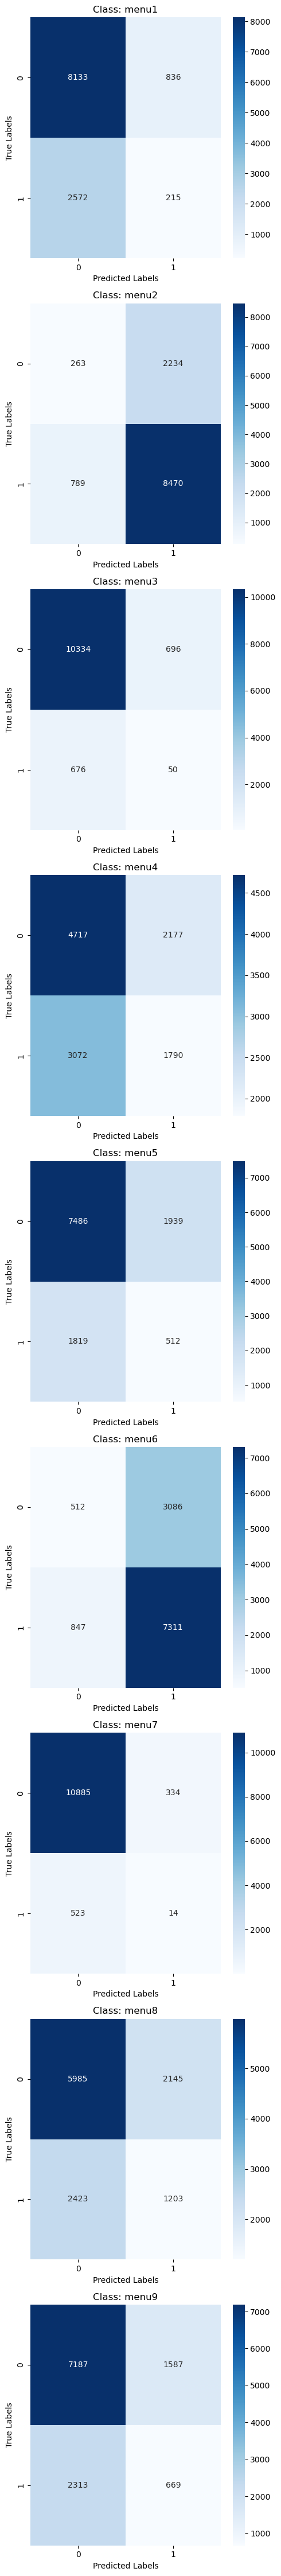

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

def plot_multilabel_confusion_matrix(y_true, y_pred, labels):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    n_labels = len(labels)
    
    fig, axes = plt.subplots(n_labels, 1, figsize=(5, 5 * n_labels))
    
    for ax, matrix, label in zip(axes, mcm, labels):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title(f'Class: {label}')
    
    plt.tight_layout()
    plt.show()

class_names = ['menu1', 'menu2', 'menu3', 'menu4', 'menu5', 'menu6', 'menu7', 'menu8', 'menu9']
plot_multilabel_confusion_matrix(y_test, y_pred_bin, class_names)



### Random Forest Classifier

In [13]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = xgb.XGBRegressor()
#model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass', verbose=200)

model.fit(X_train, y_train)
#model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=5)

RandomForestClassifier(random_state=42)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to get top k predictions
def top_k_predictions(y_pred, k=3):
    top_indices = np.argsort(y_pred, axis=1)[:, -k:]
    y_pred_bin = np.zeros_like(y_pred)
    for row, indices in enumerate(top_indices):
        y_pred_bin[row, indices] = 1
    return y_pred_bin

# Predicting the labels for the test set
y_pred = model.predict(X_test)
y_pred_bin = top_k_predictions(y_pred)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_bin)
precision = precision_score(y_test, y_pred_bin, average='samples') 
recall = recall_score(y_test, y_pred_bin, average='samples') 
f1 = f1_score(y_test, y_pred_bin, average='samples')

# Printing the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.11
Precision: 0.60
Recall: 0.60
F1 Score: 0.60


### AdaBoost Classifier

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

adb = AdaBoostClassifier()
clf = OneVsRestClassifier(adb)
clf_model = clf.fit(X_train.values, y_train.values)

In [18]:
# Predicting the labels for the test set
y_pred = clf_model.predict(X_test.values)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='samples') 
recall = recall_score(y_test, y_pred, average='samples') 
f1 = f1_score(y_test, y_pred, average='samples')

# Printing the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.04
Precision: 0.73
Recall: 0.53
F1 Score: 0.61


### Classifier Chain

In [19]:
from sklearn.multioutput import ClassifierChain

chains = [ClassifierChain(AdaBoostClassifier(), order='random', random_state=i) for i in range(y_train.shape[1])]

for chain in chains:
    chain.fit(X_train.values, y_train.values)

y_pred_chains = np.array([chain.predict(X_test.values) for chain in chains])
y_pred_chain = (y_pred_chains.mean(axis=0) >= 0.5).astype(int)

accuracy_chain = accuracy_score(y_test, y_pred_chain)
precision_chain = precision_score(y_test, y_pred_chain, average='samples') 
recall_chain = recall_score(y_test, y_pred_chain, average='samples') 
f1_chain = f1_score(y_test, y_pred_chain, average='samples')

print(f"Accuracy: {accuracy_chain:.2f}")
print(f"Precision: {precision_chain:.2f}")
print(f"Recall: {recall_chain:.2f}")
print(f"F1 Score: {f1_chain:.2f}")

Accuracy: 0.16
Precision: 0.64
Recall: 0.64
F1 Score: 0.64
